# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
import yaml

# Data Work

## Load and show raw data

In [2]:
df = pd.read_csv('shelter_intakes_data.csv')
print(f"Raw data: {len(df)} rows, {len(df.columns)} columns")

Raw data: 173812 rows, 12 columns


## Cleaning

### Part 1

In [3]:
df_clean = df.copy()

# Make naming consistent
df_clean.columns = [col.strip().replace(' ', '_').lower() for col in df_clean.columns]

# Filter out everyone but cats for this study
df_clean = df_clean[df_clean['animal_type'] == 'Cat']

# Handle Date/Time formats
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'], format='mixed') 

# Split datatime
df_clean['year'] = df_clean['datetime'].dt.year
df_clean['month'] = df_clean['datetime'].dt.month
df_clean['month_name'] = df_clean['datetime'].dt.strftime('%B')  # Full month name
df_clean['month_abbr'] = df_clean['datetime'].dt.strftime('%b')  # Abbreviated

# Remove redundunt columns
df_clean = df_clean.drop(columns=['name'])
df_clean = df_clean.drop(columns=['monthyear'])

# Check for empty rows
empty_rows = df_clean.isnull().all(axis=1)
empty_rows_count = empty_rows.sum()
print(f"# of empty rows: {empty_rows_count}")

# Handle duplicates
duplicates = df_clean.duplicated(subset=['animal_id', 'datetime'])
duplicate_count = duplicates.sum()
print(f"# of duplicate Animal IDs: {duplicate_count}")

# Check for empty cells
print(f" Empty cells count: ")
for col in df_clean.columns:
    empty_count = df_clean[col].isnull().sum()
    print(f" \t - {col}: {empty_count:,} empty cells")

print(f"# of cat intakes: {len(df_clean)}")

# of empty rows: 0
# of duplicate Animal IDs: 15
 Empty cells count: 
 	 - animal_id: 0 empty cells
 	 - datetime: 0 empty cells
 	 - found_location: 0 empty cells
 	 - intake_type: 0 empty cells
 	 - intake_condition: 0 empty cells
 	 - animal_type: 0 empty cells
 	 - sex_upon_intake: 0 empty cells
 	 - age_upon_intake: 0 empty cells
 	 - breed: 0 empty cells
 	 - color: 0 empty cells
 	 - year: 0 empty cells
 	 - month: 0 empty cells
 	 - month_name: 0 empty cells
 	 - month_abbr: 0 empty cells
# of cat intakes: 69324


In [13]:
duplicate_rows = df_clean[duplicates].sort_values('animal_id')
print(duplicate_rows)

       animal_id            datetime  \
23682    A695798 2015-01-23 11:48:00   
24370    A696688 2015-02-10 11:00:00   
48030    A727043 2016-05-17 15:46:00   
54794    A735395 2016-09-23 12:00:00   
64471    A748204 2017-04-30 16:24:00   
83406    A773428 2018-05-31 18:38:00   
90962    A782931 2018-10-23 12:29:00   
113734   A811566 2020-01-05 21:13:00   
118897   A811566 2020-07-19 10:01:00   
125830   A833777 2021-05-05 13:08:00   
141541   A860875 2022-07-05 11:26:00   
142747   A862948 2022-08-02 14:53:00   
144470   A866229 2022-09-26 15:17:00   
154576   A887327 2023-08-18 18:20:00   
166543   A912685 2024-09-04 12:23:00   

                                  found_location      intake_type  \
23682                                Austin (TX)  Owner Surrender   
24370                                Austin (TX)  Owner Surrender   
48030           9515 N Lamar Blvd in Austin (TX)            Stray   
54794                                Austin (TX)  Owner Surrender   
64471         

### Part 2

In [4]:
# Drop duplicates
df_clean = df_clean.drop_duplicates(subset=['animal_id', 'datetime'])
print(f"# of cat intakes: {len(df_clean)}")

# Re-check duplicates removal
duplicates = df_clean.duplicated(subset=['animal_id', 'datetime'])
duplicate_count = duplicates.sum()
print(f"# of duplicate Animal IDs: {duplicate_count}")

# of cat intakes: 69309
# of duplicate Animal IDs: 0


### Part 3

In [5]:
def convert_age_to_days(age_str):
    """
    Convert age string to days
    Examples:
    '1 year' -> 365
    '2 years' -> 730
    '6 months' -> 180
    '3 weeks' -> 21
    '14 days' -> 14
    """
    if pd.isna(age_str):
        return None
    
    # Convert to string and lowercase
    age_str = str(age_str).lower().strip()
    
    # Handle cases like '0 years' or '0 months'
    if age_str.startswith('0'):
        return 0
    
    # Extract number and unit
    try:
        # Split by space
        parts = age_str.split()
        if len(parts) < 2:
            return None
        
        number = float(parts[0])
        unit = parts[1]
        
        # Convert based on unit
        if 'year' in unit:
            return int(number * 365)
        elif 'month' in unit:
            return int(number * 30.44)  # Average days in month
        elif 'week' in unit:
            return int(number * 7)
        elif 'day' in unit:
            return int(number)
        else:
            return None
    except:
        return None

In [6]:
# Convert age
df_clean['age_in_days'] = df_clean['age_upon_intake'].apply(convert_age_to_days)

df_clean.head()

,animal_id,datetime,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,year,month,month_name,month_abbr,age_in_days
1,A664235,2013-10-01 08:33:00,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,2013,10,October,Oct,7
2,A664236,2013-10-01 08:33:00,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,2013,10,October,Oct,7
3,A664237,2013-10-01 08:33:00,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,2013,10,October,Oct,7
5,A664238,2013-10-01 09:33:00,Outside Jurisdiction,Stray,Normal,Cat,Unknown,4 months,American Shorthair Mix,Black/White,2013,10,October,Oct,121
7,A664256,2013-10-01 10:59:00,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,17 years,Domestic Shorthair Mix,Brown Tabby/White,2013,10,October,Oct,6205


## Cleaned data stats 

In [7]:
print(f"Cleaned data: {len(df_clean)} rows, {len(df_clean.columns)} columns")

Cleaned data: 69309 rows, 15 columns


# MongoDB

## Connect to MongoDB

In [8]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

uri = config['mongodb']['uri']
db_name = config['mongodb']['database']
collection_name = config['mongodb']['collection']

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Successfully connected!")
except Exception as e:
    print(e)

Successfully connected!


In [9]:
# Create collection
db = client[db_name]
collection = db[collection_name]

print(f"Using database: {db.name}")
print(f"Using collection: {collection.name}")

Using database: animal_shelter_analytics
Using collection: cat_intakes_cleaned


## Insert data

In [10]:
# Clear any existing data
collection.delete_many({})  

# Convert df to dictionary format
records = df_clean.to_dict('records')

# Insert in batches
batch_size = 1000
for i in range(0, len(records), batch_size):
    batch = records[i:i + batch_size]
    collection.insert_many(batch)

total_docs = collection.count_documents({})
print(f"Total documents inserted: {total_docs:,} ")

Total documents inserted: 69,309 


# Perform Seasonal Analysis 

## Cats intake by year

In [11]:
yearly_pipeline = [
    {"$group": {"_id": "$year", "count": {"$sum": 1}}},
    {"$sort": {"_id": 1}}
]

yearly_results = list(collection.aggregate(yearly_pipeline))

In [12]:
print("\n\nYearly Trend:")
print("-" * 40)

for year_data in yearly_results:
    print(f"{year_data['_id']}: {year_data['count']} cats")



Yearly Trend:
----------------------------------------
2013: 1309 cats
2014: 6937 cats
2015: 7484 cats
2016: 6632 cats
2017: 6488 cats
2018: 6018 cats
2019: 7880 cats
2020: 3448 cats
2021: 5112 cats
2022: 4684 cats
2023: 5600 cats
2024: 6046 cats
2025: 1671 cats


### Check low months for completion

#### 2013

In [13]:
df_2013 = df_clean[df_clean['year'] == 2013]

# Get unique months
months_2013 = sorted(df_2013['month_name'].unique())
month_counts = df_2013.groupby('month_name').size()
    
print(f"Months present: {months_2013}")

Months present: ['December', 'November', 'October']


#### 2025

In [14]:
df_2025 = df_clean[df_clean['year'] == 2025]

# Get unique months
months_2025 = sorted(df_2025['month_name'].unique())
month_counts = df_2025.groupby('month_name').size()
    
print(f"Months present: {months_2025}")

Months present: ['April', 'February', 'January', 'March', 'May']


In [15]:
df_may_2025 = df_2025[df_2025['month'] == 5]
df_may_2025['animal_id'].count()

65

#### 2024 (for comparison)

In [16]:
df_2024 = df_clean[df_clean['year'] == 2024]
df_may_2024 = df_2024[df_2024['month'] == 5]
df_may_2024['animal_id'].count()

887

#### 2020

In [17]:
monthly_2020 = df_clean[df_clean['year'] == 2020].groupby('month').size()

print("\n2020 Monthly Counts:")
for month, count in monthly_2020.items():
    print(f"Month {month}: {count} cats")


2020 Monthly Counts:
Month 1: 300 cats
Month 2: 278 cats
Month 3: 211 cats
Month 4: 85 cats
Month 5: 214 cats
Month 6: 405 cats
Month 7: 386 cats
Month 8: 378 cats
Month 9: 419 cats
Month 10: 390 cats
Month 11: 202 cats
Month 12: 180 cats


#### 2019 (for comparison)

In [18]:
monthly_2019 = df_clean[df_clean['year'] == 2019].groupby('month').size()

print("\n2019 Monthly Counts:")
for month, count in monthly_2019.items():
    print(f"Month {month}: {count} cats")


2019 Monthly Counts:
Month 1: 322 cats
Month 2: 297 cats
Month 3: 409 cats
Month 4: 628 cats
Month 5: 1104 cats
Month 6: 998 cats
Month 7: 876 cats
Month 8: 838 cats
Month 9: 849 cats
Month 10: 718 cats
Month 11: 513 cats
Month 12: 328 cats


## Cats intake by month

In [19]:
# MongoDB Aggregation Pipeline
pipeline = [
    {
        "$match": {
            "year": {
                "$nin": [2013, 2025]  # Exclude incomplete years
            }
        }
    },
    {
        "$group": {
            "_id": "$month_abbr",  # Group by month name
            "count": {"$sum": 1},  # Count documents
            "avg_age_days": {"$avg": "$age_in_days"},  # Average age
        }
    },
    {
        "$project": {
            "month": "$_id",
            "count": 1,
            "avg_age_years": {"$divide": ["$avg_age_days", 365]},
            "_id": 0
        }
    },
    {
        "$sort": {"count": -1}  # Sort by count descending
    }
]

# Execute the query
results = list(collection.aggregate(pipeline))

In [20]:
print("Monthly Trend:")
print("-" * 40)

for result in results:
    print(f"{result['month']:>10}: \t\t{result['count']:>6,} cats \t"
          f"Avg age: {result['avg_age_years']:.1f} years")

Monthly Trend:
----------------------------------------
       May: 		 8,916 cats 	Avg age: 0.9 years
       Jun: 		 8,180 cats 	Avg age: 0.9 years
       Jul: 		 6,983 cats 	Avg age: 1.1 years
       Aug: 		 6,688 cats 	Avg age: 1.0 years
       Sep: 		 6,583 cats 	Avg age: 1.0 years
       Oct: 		 6,171 cats 	Avg age: 1.2 years
       Apr: 		 5,481 cats 	Avg age: 1.3 years
       Nov: 		 4,435 cats 	Avg age: 1.5 years
       Mar: 		 3,496 cats 	Avg age: 2.0 years
       Dec: 		 3,443 cats 	Avg age: 1.8 years
       Jan: 		 3,207 cats 	Avg age: 2.2 years
       Feb: 		 2,746 cats 	Avg age: 2.2 years


# Visualizations

## Plot 1: Yearly Trend (2013-2025)

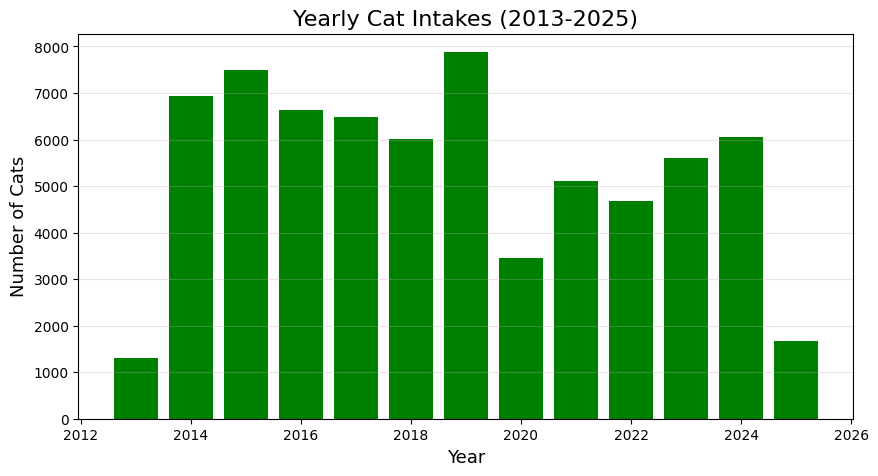

In [21]:
# Yearly trend 
yearly_counts = df_clean.groupby('year').size()

plt.figure(figsize=(10, 5))
plt.bar(yearly_counts.index, yearly_counts.values, color='green')
plt.title('Yearly Cat Intakes (2013-2025)', fontsize=16)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Number of Cats', fontsize=13)
plt.grid(axis='y', alpha=0.3)

plt.show()

## Plot 2: Monthly Trend (2014-2024)

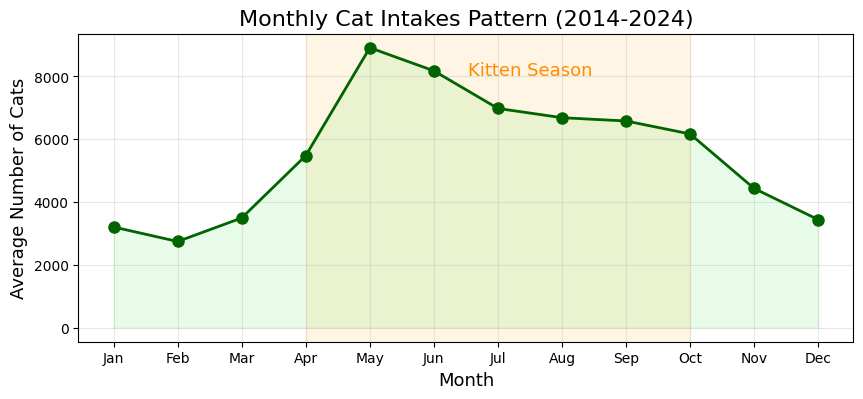

In [22]:
df_complete = df_clean[(df_clean['year'] >= 2014) & 
                                    (df_clean['year'] <= 2024)]
monthly_counts = df_complete.groupby('month').size().sort_index()

# Month names for x-axis
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(10, 4))
plt.plot(month_names, monthly_counts.values, 'o-', linewidth=2, markersize=8, color='darkgreen')
plt.fill_between(month_names, monthly_counts.values, alpha=0.2, color='lightgreen')
plt.title('Monthly Cat Intakes Pattern (2014-2024)', fontsize=16)
plt.xlabel('Month', fontsize=13)
plt.ylabel('Average Number of Cats', fontsize=13)
plt.grid(True, alpha=0.3)

# Highlight "kitten season"
plt.axvspan(3, 9, alpha=0.1, color='orange')  # April-October
plt.text(6.5, monthly_counts.max()*0.9, 'Kitten Season', 
         ha='center', fontsize=13, color='darkorange')

plt.show()

Stray kitten season is generally from early spring (March/April) through late fall (October/November), peaking in the warmer summer months.

https://www.straycatblues.org/blog/2025-kitten-season#:~:text=What%20Is%20Kitten%20Season?,experience%20their%20first%20heat%20cycle.

## Plot 3: 2020 vs 2019 Comparison

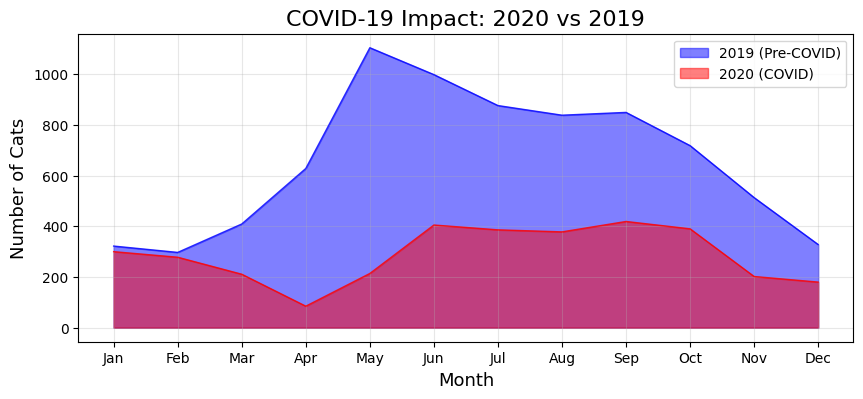

In [23]:
df_2019 = df_clean[df_clean['year'] == 2019]
df_2020 = df_clean[df_clean['year'] == 2020]

# Get monthly counts
counts_2019 = df_2019.groupby('month').size().reindex(range(1,13), fill_value=0)
counts_2020 = df_2020.groupby('month').size().reindex(range(1,13), fill_value=0)

plt.figure(figsize=(10, 4))
plt.fill_between(month_names, counts_2019, alpha=0.5, label='2019 (Pre-COVID)', color='blue')
plt.fill_between(month_names, counts_2020, alpha=0.5, label='2020 (COVID)', color='red')
plt.plot(month_names, counts_2019, 'b-', alpha=0.8, linewidth=1)
plt.plot(month_names, counts_2020, 'r-', alpha=0.8, linewidth=1)

plt.title('COVID-19 Impact: 2020 vs 2019', fontsize=16)
plt.xlabel('Month', fontsize=13)
plt.ylabel('Number of Cats', fontsize=13)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

When did quarantine start in the US?

January 31, 2020

https://www.cdc.gov/museum/timeline/covid19.html#:~:text=January%2031%2C%202020,2020%2C%20from%20Wuhan%2C%20China.

## Plot 4: Intake Types Distribution

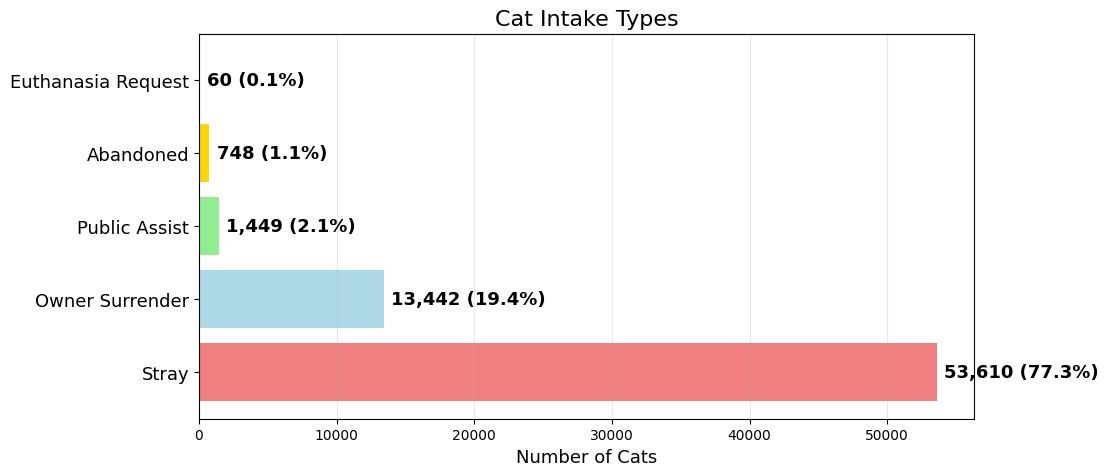

In [24]:
plt.figure(figsize=(10, 5))

# Intake types
intakes = df_clean['intake_type'].value_counts()

# Create horizontal bars
bars = plt.barh(range(len(intakes)), intakes.values, 
                color=['lightcoral', 'lightblue', 'lightgreen', 'gold', 'violet', 'pink'])

plt.title('Cat Intake Types', fontsize=16)
plt.xlabel('Number of Cats', fontsize=13)
plt.yticks(range(len(intakes)), intakes.index, fontsize=13)

# Add value labels
for i, (bar, count) in enumerate(zip(bars, intakes.values)):
    percentage = (count / sum(intakes.values)) * 100
    plt.text(bar.get_width() + max(intakes.values)*0.01, 
             bar.get_y() + bar.get_height()/2,
             f'{count:,} ({percentage:.1f}%)', 
             va='center', fontsize=13, fontweight='bold')

plt.grid(axis='x', alpha=0.3)

plt.show()

## Plot 5: Age Distribution

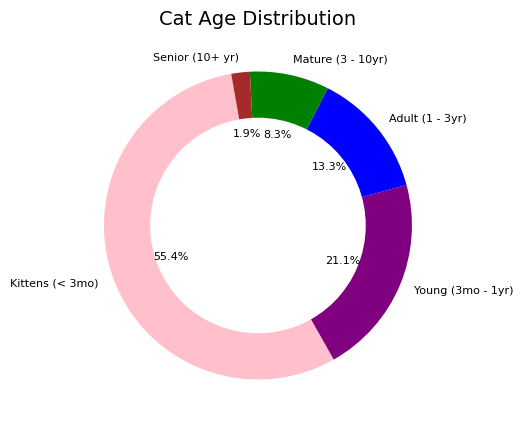

In [25]:
df_clean['age_years'] = df_clean['age_in_days'] / 365
bins = [0, 0.25, 1, 3, 10, 30]
labels = ['Kittens (< 3mo)', 'Young (3mo - 1yr)', 'Adult (1 - 3yr)', 'Mature (3 - 10yr)', 'Senior (10+ yr)']
df_clean['age_group'] = pd.cut(df_clean['age_years'], bins=bins, labels=labels)

age_counts = df_clean['age_group'].value_counts()

plt.figure(figsize=(7, 5))
wedges, texts, autotexts = plt.pie(age_counts.values, 
                                   labels=age_counts.index, 
                                   autopct='%1.1f%%',
                                   startangle=100, 
                                   colors=['pink', 'purple', 'blue', 'green', 'brown'],
                                   textprops={'fontsize': 8})

# Create donut chart
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Cat Age Distribution', fontsize=14)

plt.show()